## Amazon reviews for cell phones and accessories dataset

#### **BERT MODEL**

### Connecting to the drive

In [1]:
from google.colab import drive

drive.mount("/content/Drive")

Mounted at /content/Drive


In [2]:
import os

# Mount your Google Drive to access files stored there
drive.mount('/content/drive')

# Replace 'your_file_name.csv' with the actual name of your file.
file_name = 'Cell_Phones_and_Accessories_5.json'

# Set the root directory to your Google Drive
root_dir = '/content/drive/My Drive/'

# Function to recursively search for the file in all directories and subdirectories
def find_file(directory):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isfile(item_path) and item == file_name:
            return directory
        elif os.path.isdir(item_path):
            result = find_file(item_path)
            if result:
                return result
    return None

# Call the function to find the file directory
file_directory = find_file(root_dir)

# Print the file directory
if file_directory:
    print("File directory:", file_directory)
else:
    print("File not found in Google Drive.")


Mounted at /content/drive
File directory: /content/drive/My Drive/midterm (1)/dataset


In [3]:
os.chdir('/content/drive/My Drive/midterm (1)/dataset')

## Importing Required Libraries

In [4]:
import os
import pandas as pd

In [5]:
import numpy as np
import nltk
import json
import re
import multiprocessing as mp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [6]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

## Reading the dataset

In [7]:
# Step 1: Read the JSON file and convert it to DataFrame
df = pd.read_json('Cell_Phones_and_Accessories_5.json', lines=True)

# Now, 'df' contains the data in DataFrame format, and you can work with it as needed.


In [8]:
df.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194439 entries, 0 to 194438
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      194439 non-null  object
 1   asin            194439 non-null  object
 2   reviewerName    190920 non-null  object
 3   helpful         194439 non-null  object
 4   reviewText      194439 non-null  object
 5   overall         194439 non-null  int64 
 6   summary         194439 non-null  object
 7   unixReviewTime  194439 non-null  int64 
 8   reviewTime      194439 non-null  object
dtypes: int64(2), object(7)
memory usage: 13.4+ MB


In [10]:
# Extracting the 'reviewText' and 'overall' columns
df = df[['reviewText', 'overall']]

## Sampling data

to make it managable

In [11]:
# The percentage of data to sample
sample_percentage = 0.025

# Perform simple random sampling
sample_data = df.sample(frac=sample_percentage, random_state=42)

## Preprocessing

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [13]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Define stemmer
stemmer = PorterStemmer()

# Define lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Tokenize and remove stop words
    tokenized_text = [w for w in word_tokenize(text) if w not in stop_words]
    text = ' '.join(tokenized_text)

    # Perform stemming and lemmatization
    stemmed_lemmatized_text = [stemmer.stem(lemmatizer.lemmatize(w)) for w in word_tokenize(text)]
    text = ' '.join(stemmed_lemmatized_text)

    return text

In [14]:
sample_data['reviewText'] = sample_data['reviewText'].apply(preprocess_text)
print(sample_data)

                                               reviewText  overall
156187  ibolt xprodock activ car dock holder mount sam...        5
102252  pouch everyth look otter box commut case aroun...        5
23146   first case iphon previous one free one give al...        3
86461   order case case htc inspir case last year abso...        5
62407   bought gift big hit love choic color made devi...        5
...                                                   ...      ...
145652  work well samsung note ii charg charger rest p...        2
165116  use brand extern batteri pack et np k charger ...        5
65593   perfect case highli recommend samsung galaxi i...        5
42927   got phone upgrad week swap need soon got home ...        5
9887    lucki enough abl telecommut home full time spe...        5

[4861 rows x 2 columns]


## Splitting the dataset

In [15]:
# Split the data
train_size = int(0.7 * len(sample_data))
val_size = int(0.1 * len(sample_data))

train_data = sample_data[:train_size]
val_data = sample_data[train_size : train_size+val_size]
test_data = sample_data[train_size+val_size:]

# Extract the 'reviewText' and 'overall' fields
X_train, y_train = train_data['reviewText'], train_data['overall']
X_val, y_val = val_data['reviewText'], val_data['overall']
X_test, y_test = test_data['reviewText'], test_data['overall']

## Label Encoding

In [16]:
# create a labelencoder object
le = LabelEncoder()

# fit and transform on the data
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

## BERT Model

**BERT (Bidirectional Encoder Representations from Transformers):**
   -It is a Pre-trained transformer model for various NLP tasks. Captures context from both directions using masked language model pre-training.
   - **Advantages:** State-of-the-art performance, contextual understanding, transfer learning.
   - **Disadvantages:** Large model size, high computational demands, need for fine-tuning.

In [17]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.4 MB/s eta 0:00:00


In [22]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [20]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Converting data into tokens and creating input tensors for training
train_inputs = tokenizer(list(X_train), padding=True, truncation=True, max_length=128, return_tensors='pt')
train_labels = torch.tensor(y_train, dtype=torch.long)

train_data = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)

# Converting validation data to tokens and create input tensors for validation
val_inputs = tokenizer(list(X_val), padding=True, truncation=True, max_length=128, return_tensors='pt')
val_labels = torch.tensor(y_val, dtype=torch.long)

val_data = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_labels)
val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False)

In [24]:
# Defining optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=2e-5)

In [25]:
# Training loop
num_epochs = 5  # Finetune for 5 epochs
train_losses = []  # To track train loss
val_losses = []  # To track validation loss

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss = total_loss / len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/5, Train Loss: 1.2104, Val Loss: 1.1122
Epoch 2/5, Train Loss: 1.0355, Val Loss: 1.0320
Epoch 3/5, Train Loss: 0.8640, Val Loss: 1.0232
Epoch 4/5, Train Loss: 0.6892, Val Loss: 1.1263
Epoch 5/5, Train Loss: 0.5176, Val Loss: 1.3584


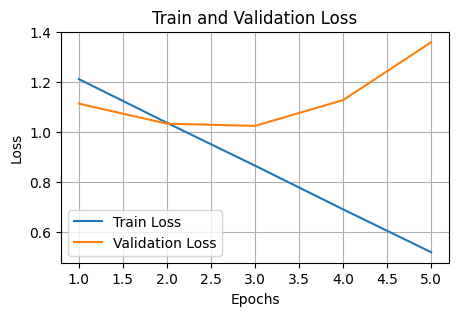

In [29]:
import matplotlib.pyplot as plt

train_losses = [1.2104, 1.0355, 0.8640, 0.6892, 0.5176]
val_losses = [1.1122, 1.0320, 1.0232, 1.1263, 1.358]

# Create a list of epochs for the x-axis
num_epochs = len(train_losses)
epochs = list(range(1, num_epochs + 1))

# Plot train and validation losses
plt.figure(figsize=(5, 3))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# Evaluate the model on the test set
test_inputs = tokenizer(list(X_test), padding=True, truncation=True, max_length=128, return_tensors='pt')
test_labels = torch.tensor(y_test, dtype=torch.long)

test_data = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)

model.eval()
correct_predictions = 0

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        predicted_labels = logits.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()

accuracy = correct_predictions / len(y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5447


## Conclusion
BERT model might have not been as good as the other models becasue the computational resources were limited, I  took only 2.5% of the data and only upto 5 epochs and it still took hours to run, as seen in the train v/s validation loss graph if we ran the data for a longer time the model could learn better and the results could potentially improve.

It could also be because BERT is a large model with numerous layers, and it might be overkill for certain tasks. If the dataset is relatively simple, a simpler model might outperform a complex one.


**The experiments provided insights into the performance trade-offs, the impact of model complexity, and the significance of leveraging pre-trained embeddings and models.**